In [12]:
%pip install openpyxl
%pip install missingno

Note: you may need to restart the kernel to use updated packages.
  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [59]:
from main_transformation import TransformationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
from gapminder import gapminder
import missingno as msno
import seaborn as sns
import pycountry
import requests

# Get data from Gapminder

In [18]:
pycountry.subdivisions.get(country_code="FR")

{Subdivision(code='FR-01', country_code='FR', name='Ain', parent='ARA', parent_code='FR-ARA', type='Metropolitan department'),
 Subdivision(code='FR-02', country_code='FR', name='Aisne', parent='HDF', parent_code='FR-HDF', type='Metropolitan department'),
 Subdivision(code='FR-03', country_code='FR', name='Allier', parent='ARA', parent_code='FR-ARA', type='Metropolitan department'),
 Subdivision(code='FR-04', country_code='FR', name='Alpes-de-Haute-Provence', parent='PAC', parent_code='FR-PAC', type='Metropolitan department'),
 Subdivision(code='FR-05', country_code='FR', name='Hautes-Alpes', parent='PAC', parent_code='FR-PAC', type='Metropolitan department'),
 Subdivision(code='FR-06', country_code='FR', name='Alpes-Maritimes', parent='PAC', parent_code='FR-PAC', type='Metropolitan department'),
 Subdivision(code='FR-07', country_code='FR', name='Ardèche', parent='ARA', parent_code='FR-ARA', type='Metropolitan department'),
 Subdivision(code='FR-08', country_code='FR', name='Ardennes'

In [20]:
pycountry.countries.get(name="Netherlands")

Country(alpha_2='NL', alpha_3='NLD', flag='🇳🇱', name='Netherlands', numeric='528', official_name='Kingdom of the Netherlands')

In [21]:
pycountry.subdivisions.get(country_code="NL")

{Subdivision(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country'),
 Subdivision(code='NL-BQ1', country_code='NL', name='Bonaire', parent_code=None, type='Special municipality'),
 Subdivision(code='NL-BQ2', country_code='NL', name='Saba', parent_code=None, type='Special municipality'),
 Subdivision(code='NL-BQ3', country_code='NL', name='Sint Eustatius', parent_code=None, type='Special municipality'),
 Subdivision(code='NL-CW', country_code='NL', name='Curaçao', parent_code=None, type='Country'),
 Subdivision(code='NL-DR', country_code='NL', name='Drenthe', parent_code=None, type='Province'),
 Subdivision(code='NL-FL', country_code='NL', name='Flevoland', parent_code=None, type='Province'),
 Subdivision(code='NL-FR', country_code='NL', name='Fryslân', parent_code=None, type='Province'),
 Subdivision(code='NL-GE', country_code='NL', name='Gelderland', parent_code=None, type='Province'),
 Subdivision(code='NL-GR', country_code='NL', name='Groningen', parent_cod

In [58]:
list(pycountry.subdivisions.get(country_code="AF"))

[Subdivision(code='AF-BAM', country_code='AF', name='Bāmyān', parent_code=None, type='Province'),
 Subdivision(code='AF-GHO', country_code='AF', name='Ghōr', parent_code=None, type='Province'),
 Subdivision(code='AF-GHA', country_code='AF', name='Ghaznī', parent_code=None, type='Province'),
 Subdivision(code='AF-KHO', country_code='AF', name='Khōst', parent_code=None, type='Province'),
 Subdivision(code='AF-PAR', country_code='AF', name='Parwān', parent_code=None, type='Province'),
 Subdivision(code='AF-ZAB', country_code='AF', name='Zābul', parent_code=None, type='Province'),
 Subdivision(code='AF-BDG', country_code='AF', name='Bādghīs', parent_code=None, type='Province'),
 Subdivision(code='AF-KNR', country_code='AF', name='Kunaṟ', parent_code=None, type='Province'),
 Subdivision(code='AF-HEL', country_code='AF', name='Helmand', parent_code=None, type='Province'),
 Subdivision(code='AF-PIA', country_code='AF', name='Paktiyā', parent_code=None, type='Province'),
 Subdivision(code='AF-

In [44]:
pycountry.countries.search_fuzzy("Micronesia")

[Country(alpha_2='FM', alpha_3='FSM', flag='🇫🇲', name='Micronesia, Federated States of', numeric='583', official_name='Federated States of Micronesia')]

In [100]:
base_url = "https://population.un.org/dataportalapi/api/v1"
target = base_url + "/locations/"

# Get the response, which includes the first page of data as well as information on pagination and number of records
response = requests.get(target)
j = response.json()
print(j)

df = pd.json_normalize(j['data']) 

# Loop until there are new pages with data
while j['nextPage'] != None:
    # Reset the target to the next page
    target = j['nextPage']

    #call the API for the next page
    response = requests.get(target)

    # Convert response to JSON format
    j = response.json()

    # Store the next page in a data frame
    df_temp = pd.json_normalize(j['data'])

    # Append next page to the data frame
    df = pd.concat([df, df_temp])

{'pageNumber': 1, 'pageSize': 100, 'previousPage': None, 'nextPage': 'https://population.un.org/dataportalapi/api/v1/locations/?pageNumber=2&pageSize=100', 'pages': 3, 'total': 298, 'data': [{'id': 4, 'name': 'Afghanistan', 'iso3': 'AFG', 'iso2': 'AF', 'longitude': 67.70995330810547, 'latitude': 33.939109802246094}, {'id': 8, 'name': 'Albania', 'iso3': 'ALB', 'iso2': 'AL', 'longitude': 20.16833114624023, 'latitude': 41.1533317565918}, {'id': 12, 'name': 'Algeria', 'iso3': 'DZA', 'iso2': 'DZ', 'longitude': 1.659626007080078, 'latitude': 28.033885955810547}, {'id': 16, 'name': 'American Samoa', 'iso3': 'ASM', 'iso2': 'AS', 'longitude': -170.69618225097656, 'latitude': -14.306020736694336}, {'id': 20, 'name': 'Andorra', 'iso3': 'AND', 'iso2': 'AD', 'longitude': 1.5218009948730469, 'latitude': 42.50628662109375}, {'id': 24, 'name': 'Angola', 'iso3': 'AGO', 'iso2': 'AO', 'longitude': 17.873886108398438, 'latitude': -11.202692031860352}, {'id': 28, 'name': 'Antigua and Barbuda', 'iso3': 'ATG

In [ ]:
def callAPI(relative_path:str, topic_list:bool = False) -> pd.DataFrame:
        base_url = "https://population.un.org/dataportalapi/api/v1" 
        target = base_url + relative_path # Query string parameters may be appended here or directly in the provided relative path
        # Calls the API
        response = requests.get(target)
        # Reformats response into a JSON object
        j = response.json()
        # The block below will deal with paginated results.
        # If results not paginated, this will be skipped.
        try:
          # If results are paginated, they are transformed into a python dictionary.
          # The data may be accessed using the 'data' key of the dictionary.
            df = pd.json_normalize(j['data'])
            # As long as the nextPage key of the dictionary contains an address for the next API call, the function will continue to call the API and append the results to the dataframe.
            while j['nextPage'] is not None:
                response = requests.get(j['nextPage'])
                j = response.json()
                df_temp = pd.json_normalize(j['data'])
                df = df.append(df_temp)
        except:
            if topic_list:
                df = pd.json_normalize(j, 'indicators')
            else:
                df = pd.DataFrame(j)
        return(df)

In [ ]:
base_url = "https://population.un.org/dataportalapi/api/v1"
target = base_url + "/locationsWithAggregates?pageNumber=0&sort=id&format=json"

# Get the response, which includes the first page of data as well as information on pagination and number of records
response = requests.get(target)

page_n = 0

try:
    df = pd.json_normalize(j['data']) 
    data_key = 'data'
except:
    df = pd.json_normalize(j[0])
    data_key = 0

# Loop until there are new pages with data
while response.status_code != 404:
    j = response.json()

    # Reset the target to the next page
    target = j['nextPage']

    #call the API for the next page
    response = requests.get(target)

    # Convert response to JSON format
    j = response.json()

    # Store the next page in a data frame
    df_temp = pd.json_normalize(j[data_key])

    # Append next page to the data frame
    df = pd.concat([df, df_temp])

[{'Id': 5544, 'Name': 'Group B – peaking (between 2025-2054)', 'Iso2': 'D9', 'Iso3': 'DA9', 'PopPeak': 'Group of countries by timing of population peak'}, {'Id': 5545, 'Name': 'Group B: Sub-Saharan Africa', 'Iso2': 'D10', 'Iso3': 'DA10', 'PopPeak': 'Group B – peaking (between 2025-2054)'}, {'Id': 5546, 'Name': 'Group B: Northern Africa and Western Asia', 'Iso2': 'D11', 'Iso3': 'DA11', 'PopPeak': 'Group B – peaking (between 2025-2054)'}, {'Id': 5547, 'Name': 'Group B: Central and Southern Asia', 'Iso2': 'D12', 'Iso3': 'DA12', 'PopPeak': 'Group B – peaking (between 2025-2054)'}, {'Id': 5548, 'Name': 'Group B: Eastern and South-Eastern Asia', 'Iso2': 'D13', 'Iso3': 'DA13', 'PopPeak': 'Group B – peaking (between 2025-2054)'}, {'Id': 5549, 'Name': 'Group B: Latin America and the Caribbean', 'Iso2': 'D14', 'Iso3': 'DA14', 'PopPeak': 'Group B – peaking (between 2025-2054)'}, {'Id': 5550, 'Name': 'Group B: Oceania (excluding Australia and New Zealand)', 'Iso2': 'D15', 'Iso3': 'DA15', 'PopPeak'

TypeError: list indices must be integers or slices, not str

In [114]:
def callAPI(relative_path:str, **query_parameters) -> pd.DataFrame:
    base_url = "https://population.un.org/dataportalapi/api/v1"
    query_string_parameters = "&".join(f"{key}={value}" for key, value in query_parameters.items())
    target = f"{base_url}/{relative_path}?{query_string_parameters}"

    # Get the response, which includes the first page of data as well as information on pagination and number of records
    response = requests.get(target)

    # Loop until there are new pages with data
    while response.status_code != 404:
        j = response.json()
        
        #Store the result in a dataframe
        if isinstance(j, list):
            df_temp = pd.json_normalize(j)
        elif isinstance(j, dict):
            df_temp = pd.json_normalize(j['data'])
        else:
            raise TypeError("Response json type is not supported")
        
        # Prepare next page api call
        if "pageNumber" in query_parameters.keys():
            query_parameters["pageNumber"] += 1
        else:
            query_parameters["pageNumber"] = 2
        
        # Append next page to the data frame
        return pd.concat([df_temp, callAPI(relative_path, **query_parameters)])
    
    return None

In [113]:
locations = callAPI("locationsWithAggregates")

{}
{'pageNumber': 2}
{'pageNumber': 3}
{'pageNumber': 4}
{'pageNumber': 5}


In [ ]:
test = {'pageNumber': 2}
"&".join(f"{key}" for key in test.items())

'pageNumber'

In [46]:
df_population, df_gapminder = TransformationPipeline().run()


----- compute Population for each country and each zone
Please, check the following list :
['Euro area', 'Caribbean small states', 'Least developed countries: UN classification', 'Europe & Central Asia (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'Early-demographic dividend', 'IDA total', 'Sub-Saharan Africa', 'OECD members', 'High income', 'Middle East & North Africa (excluding high income)', 'St. Martin (French part)', 'Other small states', 'Europe & Central Asia (IDA & IBRD countries)', 'Central Europe and the Baltics', 'Small states', 'IDA & IBRD total', 'Curacao', 'Africa Western and Central', 'Arab World', 'Isle of Man', 'Lower middle income', 'South Asia', 'Late-demographic dividend', 'Latin America & Caribbean (excluding high income)', 'Low income', 'Post-demographic dividend', 'European Union', 'Sub-Saharan Africa (excluding high income)', 'East Asia & Pacific (IDA & IBRD countries)', 'Europe & Central Asia', 'IBRD only', 'Pre-demographic dividend', 'Lo

c:\Users\Utilisateur\Documents\GitHub\shiftdataportal\data-preparation\src\transformation\demographic\population.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_gapminder = df_gapminder.applymap(lambda element: self.dirty_string_to_int(element))


In [45]:
df_population

NameError: name 'df_population' is not defined

In [3]:
def display_unique_values(s:pd.Series, df:pd.DataFrame):
    n_unique_values = df.loc[s.name, "nbr_unique_values"]
    if n_unique_values == 0:
        return "no value"
    if n_unique_values < 6:
        return ", ".join(f"{s.value_counts().index[i]} ({v} occurrences)" for i, v in enumerate(s.value_counts()))
    
    return "too many to display"


def add_additional_comment(s:pd.Series, df:pd.DataFrame, sensitivity:float):   
    value_counts = s.value_counts()

    if len(value_counts) > 0:
        # Calculate top common values based on sensitivity
        n_top_common_values = int(len(value_counts) * sensitivity)
        top_common_values = value_counts.values[:n_top_common_values]
        
        # Check if the top common values represent a significant proportion of the data
        if value_counts.quantile(1 - sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
            sum_top_common_values = top_common_values.sum()
            top_common_values_prop = round(sum_top_common_values / df.loc[s.name, "nbr_non_null_values"], 2)
            top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
            
            # Print additional comments on common values
            return f"""First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        
        return
    
    else:
        return "This column only contains null values."


def compute_modes(s:pd.Series):
    value_counts = s.value_counts()
    modes = s.mode()
    n_modes = len(modes)

    if n_modes > 0:
        return ", ".join(str(v) if i < 3 else f"... ({n_modes} elements)" for i, v in enumerate(modes[:min(n_modes, 4)])) + f" ({value_counts.values[0]} occurrence(s))"
    
    return


def get_df_variables_info(df:pd.DataFrame) -> pd.DataFrame:

    (n_rows, n_columns) = df.shape
    print(f"This DataFrame has {n_rows} rows and {n_columns} columns.")
    
    top_common_values_sensitivity = 0.15

    n_unique_values = df.nunique()
    n_values = df.count()

    df_info = pd.DataFrame({
        'column_type':df.dtypes,
        'missing_value_percentage': (df.isnull().mean()*100).round(3),
        'nbr_unique_values': n_unique_values,
        'nbr_null_values': df.isnull().sum(),
        'nbr_non_null_values': n_values,
        'duplicates_percentage':round(100-n_unique_values/(n_values.where(n_values != 0, np.nan))*100, 2),
        'mode': df.apply(compute_modes),
        'min': df.min(numeric_only=True),
        'max': df.max(numeric_only=True),
        'mean': df.mean(numeric_only=True),
        'median': df.median(numeric_only=True),
        'std': df.std(numeric_only=True)
        })

    df_info["unique_values"] = df.apply(display_unique_values, df=df_info)
    df_info["additional_comment"] = df.apply(add_additional_comment, df=df_info, sensitivity=top_common_values_sensitivity)

    return df_info


In [4]:
df_population_info = get_df_variables_info(df_population)

This DataFrame has 14272 rows and 4 columns.


In [5]:
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 46816 rows and 4 columns.


In [6]:
df_gapminder["year"] = df_gapminder["year"].astype(int)

In [7]:
df_population["year"] = df_population["year"].astype(int)

In [8]:
df_population_info = get_df_variables_info(df_population)
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 14272 rows and 4 columns.
This DataFrame has 46816 rows and 4 columns.


What countries are present in one source but not the other ?

In [27]:
additional_countries_GM = list(set(df_gapminder["group_name"]) - set(df_population["group_name"]))
print(f"Here are the countries present in source 'GapMinder' but not in source 'WBD' :")
print('\n'.join(additional_countries_GM))

Here are the countries present in source 'GapMinder' but not in source 'WBD' :
Taiwan
North Korea
Vatican
Palestine


In [26]:
additional_countries_GM = list(set(df_population["group_name"]) - set(df_gapminder["group_name"]))
print("Here are the countries present in source 'WBD' but not in source 'GapMinder' :")
print('\n'.join(additional_countries_GM))

Here are the countries present in source 'WBD' but not in source 'GapMinder' :
Gibraltar
Turks and Caicos Islands
Aruba
New Caledonia
Bermuda
Guam
Kosovo
Greenland
American Samoa
Macao Special Administrative Region (China)
British Virgin Islands
Puerto Rico
Northern Mariana Islands
United States Virgin Islands
French Polynesia
Cayman Islands
Faeroe Islands


We can assume that in GapMinder:

- United States data includes: Guam, Northern Mariana Islands, American Samoa, Puerto Rico, United States Virgin Islands
- Netherlands data includes: Aruba
- United Kingdom data includes: Gibraltar, Bermuda, British Virgin Islands, Cayman Islands, Turks and Caicos Islands
- France data includes: New Caledonia, French Polynesia
- Denmark data includes: Faroe Islands, Greenland
- China data includes: Macao Special Administrative Region (China)

However, there is no data on Kosovo

Finding reliable information on what data is actually included in each country for gapminder source seems quite complicated.

The best option seems to be maintaining both sources and aggregate them appropriately. Aggregating the data could lead to approximations and might not be ideal however.

# Add country codes

## Helper function to get country codes

In [4]:
def get_country_code(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)
        return country[0].alpha_3
    except:
        return None

In [5]:
get_country_code("France")

'FRA'

## Create mapping table

In [1]:
all_countries = list(gapminder["country"].unique())
len(all_countries)

NameError: name 'gapminder' is not defined

In [10]:
country_mapping = []
for country in all_countries:
    country_mapping.append({"country":country,"country_code":get_country_code(country)})
country_mapping = pd.DataFrame(country_mapping)
country_mapping.head()

,country,country_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Angola,AGO
4,Argentina,ARG


# Visualisation

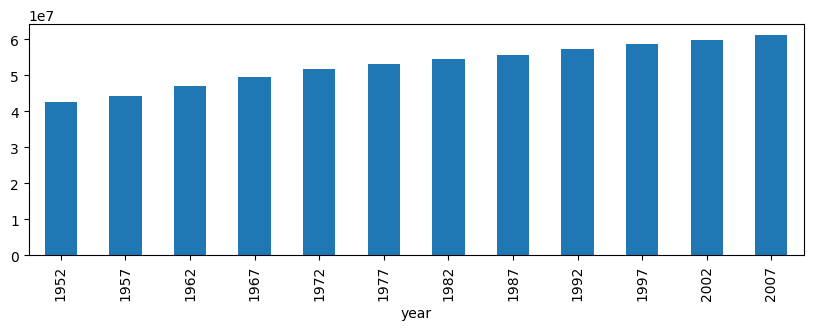

In [23]:
population_data.query("country_code=='FRA'").set_index("year")["pop"].plot(kind = "bar",figsize = (10,3))
plt.show()